In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pandas as pd
import yaml


root_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath("."))))
sys.path.append(root_dir)

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple
from scipy.stats import sem, t
import torch
import pickle

import seaborn as sns
sns.set_theme()

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_6504\2439567846.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def tuple_constructor(loader, node):
    return tuple(loader.construct_sequence(node))


def generic_constructor(loader, tag_suffix, node):
    if isinstance(node, yaml.MappingNode):
        # Attempt to handle unhashable keys by converting them to a string representation
        # This is a workaround and might need adjustment based on specific use cases
        return {
            str(loader.construct_object(key)): loader.construct_object(value)
            for key, value in node.value
        }
    elif isinstance(node, yaml.SequenceNode):
        return [loader.construct_object(child) for child in node.value]
    elif isinstance(node, yaml.ScalarNode):
        return loader.construct_scalar(node)
    
yaml.SafeLoader.add_constructor("tag:yaml.org,2002:python/tuple", tuple_constructor)
yaml.SafeLoader.add_multi_constructor("", generic_constructor)

In [4]:
root_dir = r".\results\2024Aug07-003618_config_sparse_rb" # bigger room, big network

### Look at the metrics

In [5]:
def parse_title_string(input_string, prefix=""):
    key_value_pairs = input_string.split("; ")
    result_dict = {}
    
    for pair in key_value_pairs:
        key, value = pair.split("=")
        result_dict[f"{prefix}{key}"] = value
    
    return result_dict

def flatten_metrics(metrics, prefix):
    # Initialize an empty list to collect processed data
    data = []

    # Iterate over each metric log
    for metric in metrics:
        
        # Flatten the nested dictionary structure for each metric log
        flat_metric = {
            f"{prefix}_frame_stamp": metric["frame_stamp"],
        }

        if "epsilon_greedy" in metric:
            flat_metric[f"{prefix}_epsilon_greedy"] = metric["epsilon_greedy"]

        metric_keys = ["episode_rewards", "episode_frames", "episode_losses", "episode_max_qs"]

        # Iterate over each metric key
        for key in metric_keys:
            # Check if the metric key exists in the metric dictionary
            if key in metric:
                # Add the corresponding statistics to flat_metric
                for stat_name, value in metric[key].items():
                    flat_metric[f"{prefix}_{key}_{stat_name}"] = value

                # Append the flattened metric to the data list
                data.append(flat_metric)

    # Convert the data list to a DataFrame
    return pd.DataFrame(data)


def collect_experiment_data_per_epoch(root_dir):
    """
    Collects experiment data and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected data and parameters.
    """
    all_data = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith("inverted_pendulum_train_stats"):
                # Path to the current metrics file
                file_path = os.path.join(subdir, file)

                # Load the metrics data with torch
                try:
                    metrics_data = torch.load(file_path)
                except FileNotFoundError:
                    print(f"Metrics file not found: {file_path}. Skipping...")
                    continue

                # Process the metrics data
                df_training_metrics = flatten_metrics(
                    metrics_data.get("training_stats", []), "training"
                )
                df_validation_metrics = flatten_metrics(
                    metrics_data.get("validation_stats", []), "validation"
                )

                # Combine training and validation metrics if both are available
                if not df_training_metrics.empty and not df_validation_metrics.empty:
                    df_metrics = pd.concat(
                        [df_training_metrics, df_validation_metrics], axis=1
                    )
                elif not df_training_metrics.empty:
                    df_metrics = df_training_metrics
                else:
                    df_metrics = df_validation_metrics

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                try:
                    with open(cfg_path, "r") as cfg_file:
                        cfg_data = yaml.safe_load(cfg_file)
                except FileNotFoundError:
                    print(f"Configuration file not found for {file_path}. Skipping...")
                    continue

                # Extract parameters from the configuration file
                for param, value in cfg_data.items():
                    if isinstance(value, dict):
                        for sub_param, sub_value in value.items():
                            df_metrics[f"{param}_{sub_param}"] = sub_value
                    elif isinstance(value, tuple):
                        df_metrics[param] = str(value)
                    elif isinstance(value, list):
                        df_metrics[param] = str(value)
                    else:
                        df_metrics[param] = value
                        
                if "title" in cfg_data:
                    title_args_dict = parse_title_string(cfg_data.get("title"), prefix="exp_arg_")
                    for key, value in title_args_dict.items():
                        df_metrics[key] = value
                        
                # Append to the list of all data
                all_data.append(df_metrics)

    # Concatenate all data into a single DataFrame if not empty, otherwise return an empty DataFrame
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()


# Example usage:
combined_data = collect_experiment_data_per_epoch(root_dir)
combined_data

,training_frame_stamp,training_epsilon_greedy,training_episode_rewards_min,training_episode_rewards_max,training_episode_rewards_mean,training_episode_rewards_median,training_episode_rewards_std,training_episode_frames_min,training_episode_frames_max,training_episode_frames_mean,...,replay_buffer_type,run_id,seed,title,train_max_iterations,exp_arg_replay_buffer.knn_neighbors,exp_arg_replay_buffer.sample_distance_threshold,exp_arg_optim.args_.eps,exp_arg_optim.args_.lr,exp_arg_agent_params.args_.hidden_size
0,10000,0.9703,147.881880,273.087746,227.464315,229.383695,35.655261,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,0.0001,0.001,16
1,10000,0.9703,147.881880,273.087746,227.464315,229.383695,35.655261,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,0.0001,0.001,16
2,10000,0.9703,147.881880,273.087746,227.464315,229.383695,35.655261,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,0.0001,0.001,16
3,10000,0.9703,147.881880,273.087746,227.464315,229.383695,35.655261,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,0.0001,0.001,16
4,20000,0.9373,57.990475,258.438528,190.718300,204.163384,65.151930,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,0.0001,0.001,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76795,590000,0.0100,271.782967,990.224573,915.224968,987.486058,214.500645,1000,1000,1000.0,...,SparseReplayBuffer,4,None,replay_buffer.knn_neighbors=10; replay_buffer....,60,10,0.05,1e-05,0.001,128
76796,600000,0.0100,273.700117,986.994383,880.493505,975.689910,208.564522,1000,1000,1000.0,...,SparseReplayBuffer,4,None,replay_buffer.knn_neighbors=10; replay_buffer....,60,10,0.05,1e-05,0.001,128
76797,600000,0.0100,273.700117,986.994383,880.493505,975.689910,208.564522,1000,1000,1000.0,...,SparseReplayBuffer,4,None,replay_buffer.knn_neighbors=10; replay_buffer....,60,10,0.05,1e-05,0.001,128
76798,600000,0.0100,273.700117,986.994383,880.493505,975.689910,208.564522,1000,1000,1000.0,...,SparseReplayBuffer,4,None,replay_buffer.knn_neighbors=10; replay_buffer....,60,10,0.05,1e-05,0.001,128


In [6]:
combined_data.columns

Index(['training_frame_stamp', 'training_epsilon_greedy',
       'training_episode_rewards_min', 'training_episode_rewards_max',
       'training_episode_rewards_mean', 'training_episode_rewards_median',
       'training_episode_rewards_std', 'training_episode_frames_min',
       'training_episode_frames_max', 'training_episode_frames_mean',
       'training_episode_frames_median', 'training_episode_frames_std',
       'training_episode_losses_min', 'training_episode_losses_max',
       'training_episode_losses_mean', 'training_episode_losses_median',
       'training_episode_losses_std', 'training_episode_max_qs_min',
       'training_episode_max_qs_max', 'training_episode_max_qs_mean',
       'training_episode_max_qs_median', 'training_episode_max_qs_std',
       'validation_frame_stamp', 'validation_episode_rewards_min',
       'validation_episode_rewards_max', 'validation_episode_rewards_mean',
       'validation_episode_rewards_median', 'validation_episode_rewards_std',
       'va

In [7]:
[col for col in combined_data.columns if "exp_arg_" in col]


['exp_arg_replay_buffer.knn_neighbors',
 'exp_arg_replay_buffer.sample_distance_threshold',
 'exp_arg_optim.args_.eps',
 'exp_arg_optim.args_.lr',
 'exp_arg_agent_params.args_.hidden_size']

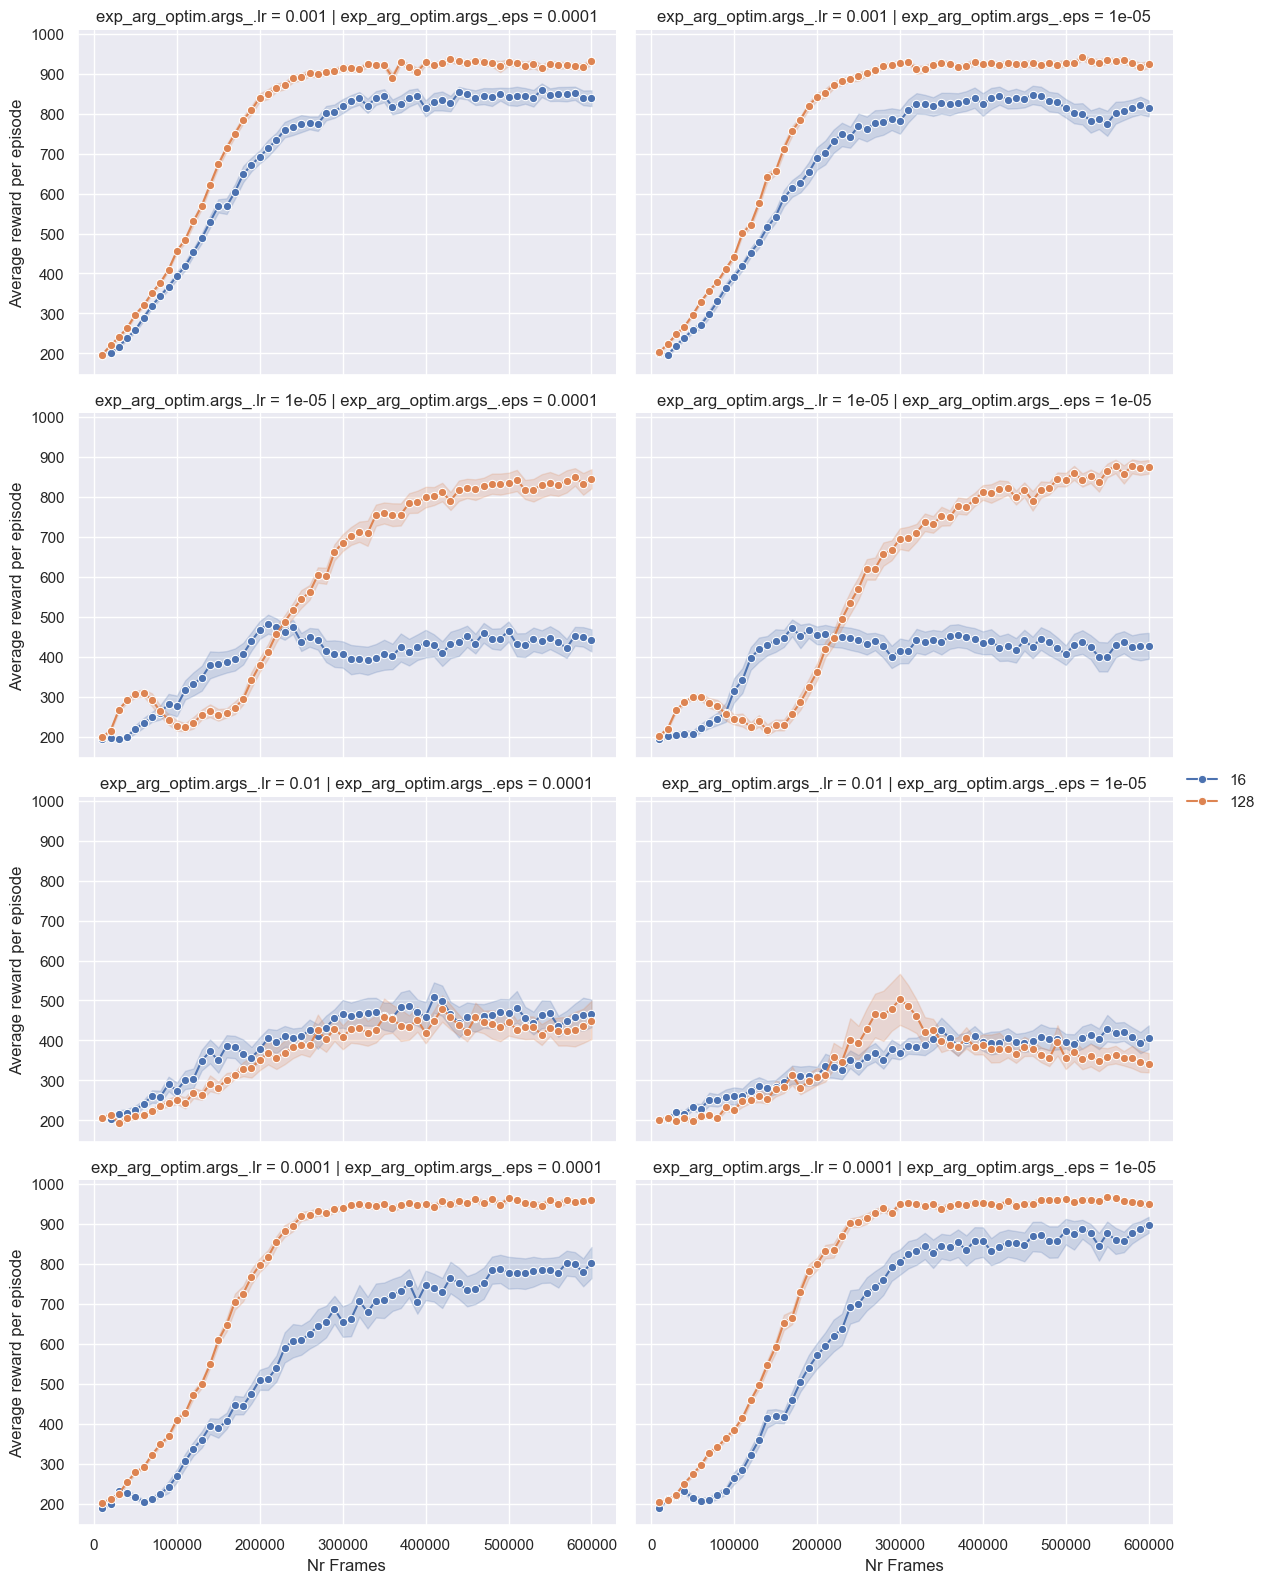

In [8]:
g = sns.FacetGrid(
    combined_data,
    row="exp_arg_optim.args_.lr",
    col="exp_arg_optim.args_.eps",
    # col_wrap=3,
    height=4,
    aspect=1.5,
)

# Map the lineplot to the FacetGrid
g.map_dataframe(
    sns.lineplot,
    x="training_frame_stamp",
    y="training_episode_rewards_mean",
    hue="exp_arg_agent_params.args_.hidden_size",
    marker="o",
    errorbar="ci",
)

# Add axis labels and titles
g.set_axis_labels("Nr Frames", "Average reward per episode")
g.add_legend()

# Display the plot
plt.show()

In [9]:
combined_data

,training_frame_stamp,training_epsilon_greedy,training_episode_rewards_min,training_episode_rewards_max,training_episode_rewards_mean,training_episode_rewards_median,training_episode_rewards_std,training_episode_frames_min,training_episode_frames_max,training_episode_frames_mean,...,replay_buffer_type,run_id,seed,title,train_max_iterations,exp_arg_replay_buffer.knn_neighbors,exp_arg_replay_buffer.sample_distance_threshold,exp_arg_optim.args_.eps,exp_arg_optim.args_.lr,exp_arg_agent_params.args_.hidden_size
0,10000,0.9703,147.881880,273.087746,227.464315,229.383695,35.655261,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,0.0001,0.001,16
1,10000,0.9703,147.881880,273.087746,227.464315,229.383695,35.655261,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,0.0001,0.001,16
2,10000,0.9703,147.881880,273.087746,227.464315,229.383695,35.655261,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,0.0001,0.001,16
3,10000,0.9703,147.881880,273.087746,227.464315,229.383695,35.655261,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,0.0001,0.001,16
4,20000,0.9373,57.990475,258.438528,190.718300,204.163384,65.151930,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,0.0001,0.001,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76795,590000,0.0100,271.782967,990.224573,915.224968,987.486058,214.500645,1000,1000,1000.0,...,SparseReplayBuffer,4,None,replay_buffer.knn_neighbors=10; replay_buffer....,60,10,0.05,1e-05,0.001,128
76796,600000,0.0100,273.700117,986.994383,880.493505,975.689910,208.564522,1000,1000,1000.0,...,SparseReplayBuffer,4,None,replay_buffer.knn_neighbors=10; replay_buffer....,60,10,0.05,1e-05,0.001,128
76797,600000,0.0100,273.700117,986.994383,880.493505,975.689910,208.564522,1000,1000,1000.0,...,SparseReplayBuffer,4,None,replay_buffer.knn_neighbors=10; replay_buffer....,60,10,0.05,1e-05,0.001,128
76798,600000,0.0100,273.700117,986.994383,880.493505,975.689910,208.564522,1000,1000,1000.0,...,SparseReplayBuffer,4,None,replay_buffer.knn_neighbors=10; replay_buffer....,60,10,0.05,1e-05,0.001,128


In [10]:
# Select best lr eps combo
sub_combined_data = combined_data[
    (combined_data["exp_arg_optim.args_.lr"]=="0.001")
    & (combined_data["exp_arg_optim.args_.eps"]=="1e-05")]

sub_combined_data

,training_frame_stamp,training_epsilon_greedy,training_episode_rewards_min,training_episode_rewards_max,training_episode_rewards_mean,training_episode_rewards_median,training_episode_rewards_std,training_episode_frames_min,training_episode_frames_max,training_episode_frames_mean,...,replay_buffer_type,run_id,seed,title,train_max_iterations,exp_arg_replay_buffer.knn_neighbors,exp_arg_replay_buffer.sample_distance_threshold,exp_arg_optim.args_.eps,exp_arg_optim.args_.lr,exp_arg_agent_params.args_.hidden_size
9600,10000,0.9703,55.758019,272.880483,204.419615,210.520096,58.033973,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,1e-05,0.001,16
9601,10000,0.9703,55.758019,272.880483,204.419615,210.520096,58.033973,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,1e-05,0.001,16
9602,10000,0.9703,55.758019,272.880483,204.419615,210.520096,58.033973,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,1e-05,0.001,16
9603,10000,0.9703,55.758019,272.880483,204.419615,210.520096,58.033973,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,1e-05,0.001,16
9604,20000,0.9373,137.557107,260.678964,196.380753,187.270089,34.473560,1000,1000,1000.0,...,SparseReplayBuffer,0,None,replay_buffer.knn_neighbors=1; replay_buffer.s...,60,1,0.1,1e-05,0.001,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76795,590000,0.0100,271.782967,990.224573,915.224968,987.486058,214.500645,1000,1000,1000.0,...,SparseReplayBuffer,4,None,replay_buffer.knn_neighbors=10; replay_buffer....,60,10,0.05,1e-05,0.001,128
76796,600000,0.0100,273.700117,986.994383,880.493505,975.689910,208.564522,1000,1000,1000.0,...,SparseReplayBuffer,4,None,replay_buffer.knn_neighbors=10; replay_buffer....,60,10,0.05,1e-05,0.001,128
76797,600000,0.0100,273.700117,986.994383,880.493505,975.689910,208.564522,1000,1000,1000.0,...,SparseReplayBuffer,4,None,replay_buffer.knn_neighbors=10; replay_buffer....,60,10,0.05,1e-05,0.001,128
76798,600000,0.0100,273.700117,986.994383,880.493505,975.689910,208.564522,1000,1000,1000.0,...,SparseReplayBuffer,4,None,replay_buffer.knn_neighbors=10; replay_buffer....,60,10,0.05,1e-05,0.001,128


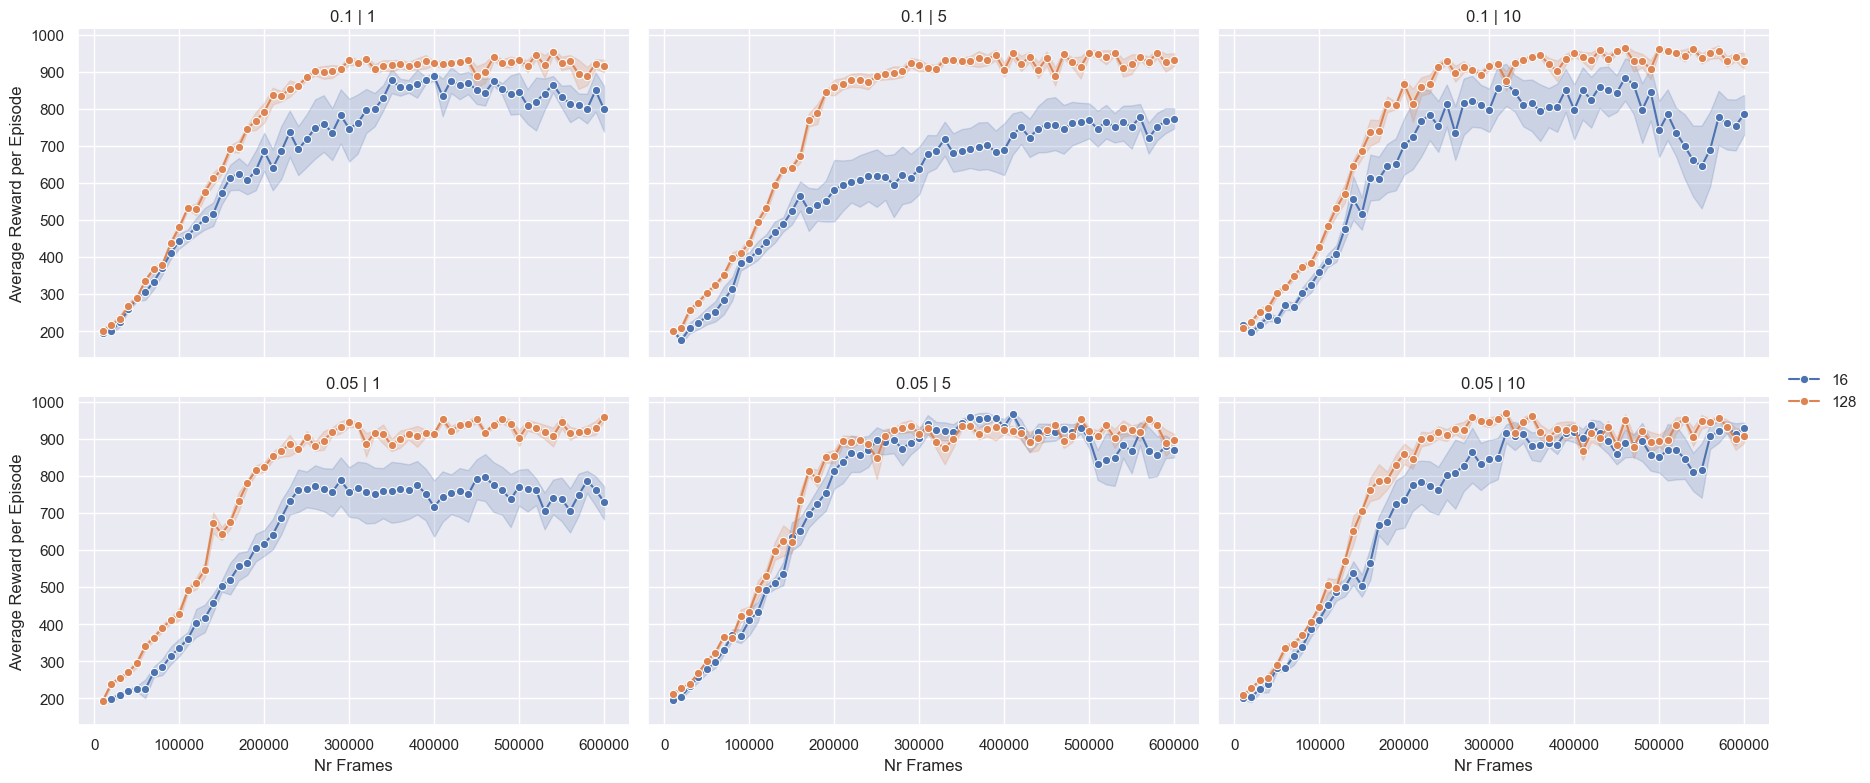

In [17]:
# Create a copy of the DataFrame with shorter column names
sub_combined_data_short = sub_combined_data.rename(columns={
    "exp_arg_replay_buffer.sample_distance_threshold": "sample_dist_thresh",
    "exp_arg_replay_buffer.knn_neighbors": "knn_neighbors",
    "exp_arg_agent_params.args_.hidden_size": "hidden_size",
    "training_frame_stamp": "frames",
    "training_episode_rewards_mean": "mean_reward"
})

# Create the FacetGrid with shorter names
g = sns.FacetGrid(
    sub_combined_data_short,
    row="sample_dist_thresh",
    col="knn_neighbors",
    height=4,
    aspect=1.5,
)

# Map the lineplot to the FacetGrid
g.map_dataframe(
    sns.lineplot,
    x="frames",
    y="mean_reward",
    hue="hidden_size",
    marker="o",
    errorbar="ci",
)

# Add axis labels and titles
g.set_axis_labels("Nr Frames", "Average Reward per Episode")
g.add_legend()

# Custom titles for rows and columns
g.set_titles(row_template="{row_name}", col_template="{col_name}")

# Display the plot
plt.show()

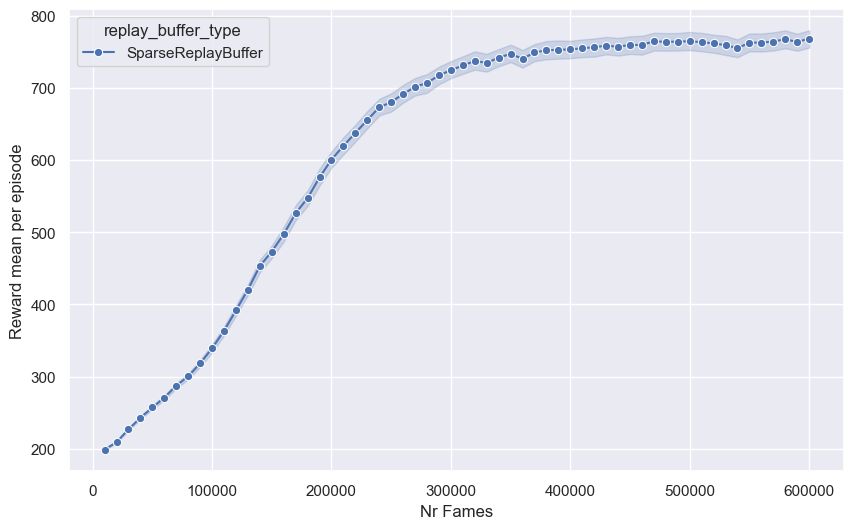

In [12]:
plt.figure(figsize=(10, 6))

# Plot experiment data
sns.lineplot(
    data=combined_data,
    x="training_frame_stamp",
    y="training_episode_rewards_mean",
    hue="replay_buffer_type",
    marker="o",
    errorbar="ci",
    #  errorbar=("pi", 100)
)

plt.xlabel("Nr Fames")
plt.ylabel("Reward mean per episode")
# plt.xscale("log")
# plt.yscale("log")

plt.show()

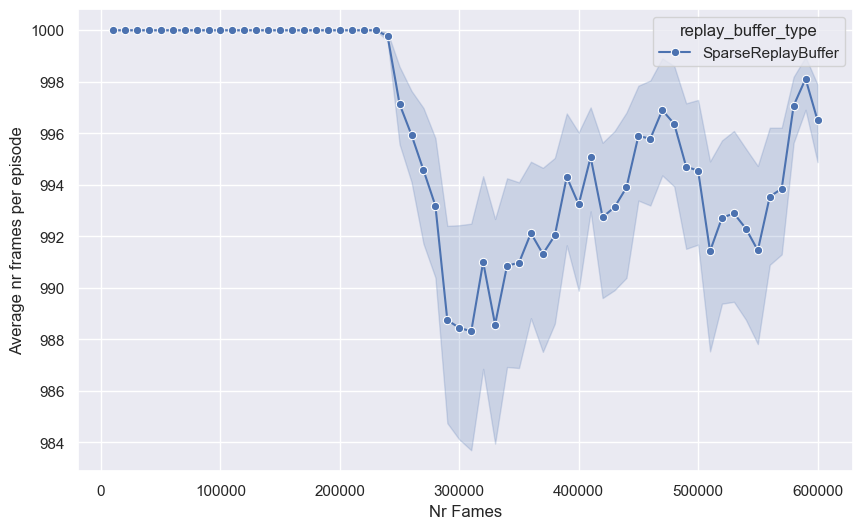

In [13]:
plt.figure(figsize=(10, 6))

# Plot experiment data
sns.lineplot(
    data=combined_data,
    x="training_frame_stamp",
    y="training_episode_frames_mean",
    hue="replay_buffer_type",
    marker="o",
    errorbar="ci",
    #  errorbar=("pi", 100)
)

plt.xlabel("Nr Fames")
plt.ylabel("Average nr frames per episode")
# plt.xscale("log")
# plt.yscale("log")

plt.show()

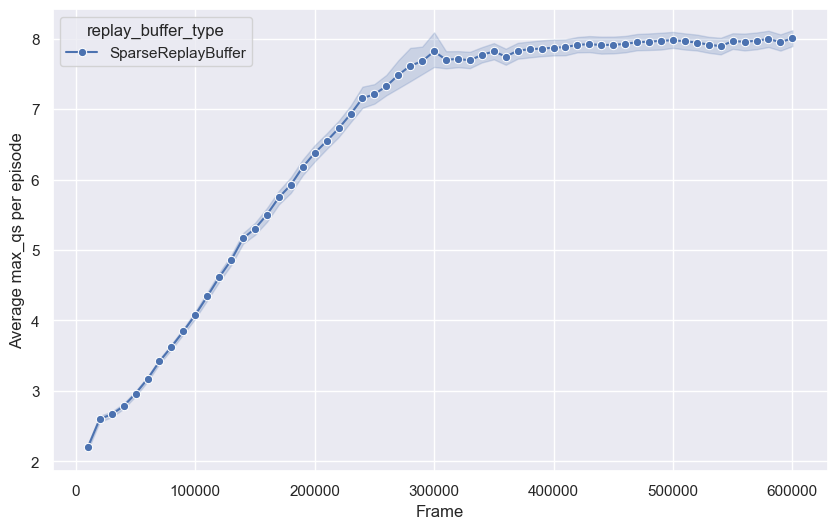

In [14]:
plt.figure(figsize=(10, 6))

# Plot experiment data
sns.lineplot(
    data=combined_data,
    x="training_frame_stamp",
    y="training_episode_max_qs_mean",
    hue="replay_buffer_type",
    marker="o",
    errorbar="ci",
    #  errorbar=("pi", 100)
)


# Adjustments to plot aesthetics
plt.xlabel("Frame")
plt.ylabel("Average max_qs per episode")
# plt.xscale("log")
# plt.yscale("log")

plt.show()

In [15]:
# Skip below

In [16]:
# Assuming baseline_errors_df is your dataframe
n = len(baseline_errors_df["validation_error"])  # Number of samples
baseline_avg_bellman_error = baseline_errors_df["validation_error"].mean()
baseline_std_dev = baseline_errors_df["validation_error"].std()
baseline_sem = sem(
    baseline_errors_df["validation_error"], nan_policy="omit"
)  # Calculate the SEM

# Confidence interval calculation (95% confidence)
t_critical = t.ppf(0.975, n - 1)  # Two-tailed t-value for 95% confidence
ci_range = t_critical * baseline_sem

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=experiment_data_df,
    x="tau",
    y="bellman_error",
    hue="model",
    marker="o",
    errorbar="ci",
    #  errorbar=("pi", 100)
)

tau_min = experiment_data_df["tau"].min()
tau_max = experiment_data_df["tau"].max()

# Plot the mean line
plt.plot(
    [tau_min, tau_max],
    [baseline_avg_bellman_error, baseline_avg_bellman_error],
    linestyle="--",
    color="darkred",
)

# Plot the confidence interval around the mean
x_values = np.logspace(np.log10(tau_min), np.log10(tau_max), num=100)

plt.fill_between(
    x_values,
    [baseline_avg_bellman_error - ci_range] * len(x_values),
    [baseline_avg_bellman_error + ci_range] * len(x_values),
    color="darkred",
    alpha=0.2,
    label="Baseline - validation error",
)

plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")
plt.legend()

plt.show()

NameError: name 'baseline_errors_df' is not defined

In [ ]:
# # With access to seeds, check why some examles have much lower bellman errors:

# from common.src.distribution_src import (
#     train_net_with_neural_fitting,
#     generate_random_policy_transitions,
#     generate_transitions_observations,
#     generate_train_test_split_with_valid_path,
#     make_env,
# )
# from common.src.experiment_utils import setup_logger, seed_everything

# seed = 3
# start_state = (0, 0)
# terminal_states = {(8, 8): 1}
# rows = 10
# cols = 10
# p_success = 1.0
# num_steps = 40_000
# tau = 10
# min_samples = 10


# def experiment_sample(
#     seed,
#     start_state,
#     terminal_states,
#     rows,
#     cols,
#     p_success,
#     num_steps,
#     tau,
#     min_samples,
# ):
#     seed_everything(seed)

#     env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

#     states = list(set([s for s, _ in env.mdp.keys()]))
#     actions = list(set([a for _, a in env.mdp.keys()]))

#     transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

#     transitions_train, transitions_val = generate_train_test_split_with_valid_path(
#         transitions_list=transitions_list,
#         start_state=start_state,
#         terminal_states=terminal_states,
#         seed=seed,
#     )

#     train_dataset_transitions = generate_transitions_observations(
#         transitions_train, num_steps, tau, min_samples=min_samples
#     )

#     return train_dataset_transitions


# samples = experiment_sample(
#     seed,
#     start_state,
#     terminal_states,
#     rows,
#     cols,
#     p_success,
#     num_steps,
#     tau,
#     min_samples,
# )

In [ ]:
# def sum_rewards(transitions):
#     return sum(transition[3] for transition in transitions)


# def count_transitions_terminal(transitions, target_value=1.0):
#     transition_counts = {}
#     for transition in transitions:
#         if transition[3] == target_value:
#             key = tuple(transition[:3])
#             transition_counts[key] = transition_counts.get(key, 0) + 1
#     return transition_counts


# def count_transitions(transitions):
#     transition_counts = {}
#     for transition in transitions:
#         key = tuple(transition[:3])
#         transition_counts[key] = transition_counts.get(key, 0) + 1
#     return transition_counts


# samples = experiment_sample(
#     seed,
#     start_state,
#     terminal_states,
#     rows,
#     cols,
#     p_success,
#     num_steps,
#     tau,
#     min_samples,
# )

# sum_rewards(samples)
# t_counts = count_transitions(samples)
# # len(t_counts)
# # t_counts

In [ ]:
# def process_row(row):
#     try:

#         terminal_states = {(8, 8): 1.0}

#         start_state = (1, 1)

#         train_dataset_transitions = experiment_sample(

#             seed=row["seed"],
#             start_state=start_state,
#             terminal_states=terminal_states,

#             rows=row["rows"],

#             cols=row["cols"],

#             p_success=row["p_success"],

#             num_steps=row["num_steps"],

#             tau=row["tau"],

#             min_samples=row["min_samples"],

#         )


#         sum_of_rewards = sum_rewards(train_dataset_transitions)

#         terminal_t_counts = count_transitions_terminal(train_dataset_transitions)

#         transition_counts = count_transitions(train_dataset_transitions)


#     except Exception as e:
#         print(row.to_dict())
#         raise e


#     # Assuming the count_transitions function returns a count you want directly; if it's more complex, adjust accordingly.

#     return pd.Series(
#         [sum_of_rewards, len(terminal_t_counts), len(transition_counts)],
#         index=["sum_rewards", "distinct_terminal_states", "distinct_transitions"],
#     )



# results_df = bellman_errors_df.apply(process_row, axis=1)


# # Concatenate the new results with the original DataFrame

# df_with_results = pd.concat([bellman_errors_df, results_df], axis=1)

# df_with_results

In [ ]:
# fail_dict = {'model': 'qnet_original',
#              'bellman_error': 0.3328666090965271,
#              'alpha': 0.1,
#              'batch_size': 32,
#              'cfg_id': 1,
#              'cols': 10,
#              'epsilon': 0.01,
#              'experiment': 'experiment_distributions',
#              'experiment_arguments_min_samples': 10,
#              'experiment_arguments_tau': 0.01,
#              'full_title': '2024Apr15-163128_configs_tau=0.01; min_samples=10',
#              'gamma': 0.9,
#              'min_samples': 10,
#              'num_steps': 40000,
#              'out_dir': '.\\results\\2024Apr15-163128_configs\\0001_tau_0.01__min_samples_10\\12',
#              'p_success': 1,
#              'rows': 10,
#              'run_id': 12,
#              'seed': 3211944324,
#              'start_state': 1,
#              'tau': 0.01,
#              'terminal_states_(8, 8)': 1.0,
#              'title': 'tau=0.01; min_samples=10',
#              'train_max_iterations': 30}

# seed = fail_dict["seed"]
# rows = fail_dict["rows"]
# cols = fail_dict["cols"]
# p_success = fail_dict["p_success"]
# num_steps = fail_dict["num_steps"]
# tau = fail_dict["tau"]
# min_samples = fail_dict["min_samples"]
# terminal_states = {(8, 8): 1.0}
# start_state = (1, 1)

# seed_everything(seed)

# env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

# states = list(set([s for s, _ in env.mdp.keys()]))
# actions = list(set([a for _, a in env.mdp.keys()]))

# transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

# transitions_train, transitions_val = generate_train_test_split_with_valid_path(
#     transitions_list=transitions_list,
#     start_state=start_state,
#     terminal_states=terminal_states,
#     seed=seed,
# )

# # train_dataset_transitions = generate_transitions_observations(
# #     transitions_train, num_steps, tau, min_samples=min_samples
# # )

In [ ]:
# sns.scatterplot(
#     data=df_with_results, x="distinct_transitions", y="bellman_error", hue="model"
# )

# # plt.xscale("log")

# plt.yscale("log")

# plt.show()

In [ ]:
# sns.scatterplot(data=df_with_results, x="sum_rewards", y="bellman_error", hue="model")
# # plt.xscale("log")
# plt.yscale("log")
# plt.show()

In [ ]:
# sns.scatterplot(
#     data=df_with_results, x="distinct_terminal_states", y="bellman_error", hue="model"
# )

# # plt.xscale("log")

# plt.yscale("log")

# plt.show()

### Plot distributions of transitions

In [ ]:
# def plot_state_counts_heatmap(transitions, title="State Counts"):
#     # Convert dataset to DataFrame
#     columns = ["state", "action", "next_state", "reward", "done", "prob"]
#     df = pd.DataFrame(transitions, columns=columns)

#     # Split state and next_state into separate columns for rows and cols
#     df[["state_row", "state_col"]] = pd.DataFrame(df["state"].tolist(), index=df.index)
#     df[["next_state_row", "next_state_col"]] = pd.DataFrame(
#         df["next_state"].tolist(), index=df.index
#     )

#     # Group by state positions to count occurrences
#     train_state_counts = (
#         df.groupby(["state_row", "state_col"]).size().reset_index(name="counts")
#     )

#     # Pivot the counts data for heatmap plotting
#     train_state_heatmap = train_state_counts.pivot(
#         index="state_row", columns="state_col", values="counts"
#     )

#     # Plotting
#     plt.figure(figsize=(12, 6))
#     sns.heatmap(train_state_heatmap, annot=False, cmap="YlGnBu", cbar=True)
#     plt.title(title)
#     plt.xlabel("State Column")
#     plt.ylabel("State Row")
#     plt.show()

In [ ]:
# idx_min = bellman_errors_df.groupby("tau")["bellman_error"].idxmin()
# idx_max = bellman_errors_df.groupby("tau")["bellman_error"].idxmax()

# # Use the indices to select the rows
# min_bellman_errors_df = bellman_errors_df.loc[idx_min]
# max_bellman_errors_df = bellman_errors_df.loc[idx_max]

# # Combine the min and max rows into a single DataFrame
# # To ensure no duplicates if min and max are the same row, use pd.concat with drop_duplicates
# result_df = pd.concat([min_bellman_errors_df, max_bellman_errors_df]).drop_duplicates()

# ### Histogram of transitions

# for index, row in result_df.iterrows():

#     terminal_states = {(8, 8): 1.0}

#     start_state = (1, 1)


#     # Call experiment_sample with the current row's data

#     train_dataset_transitions = experiment_sample(
#         seed=row["seed"],
#         start_state=start_state,
#         terminal_states=terminal_states,
#         rows=row["rows"],
#         cols=row["cols"],
#         p_success=row["p_success"],
#         num_steps=row["num_steps"],
#         tau=row["tau"],
#         min_samples=row["min_samples"],
#     )

#     plot_state_counts_heatmap(train_dataset_transitions, title=f"{row['tau']}")

#     # # Compute the desired metrics
#     # sum_of_rewards = sum_rewards(train_dataset_transitions)
#     # terminal_t_counts = count_transitions_terminal(train_dataset_transitions)
#     # transition_counts = count_transitions(train_dataset_transitions)

#     # data = {

#     #     "Transitions": [f"{key[0]} {key[1]} {key[2]}" for key in transition_counts.keys()],

#     #     "Counts": list(transition_counts.values())

#     # }


#     # df = pd.DataFrame(data)

#     # plt.figure(figsize=(10, 6))

#     # sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


#     # # Adding titles and labels

#     # plt.title(f'{row["model"]}, {row["tau"]}, {row["min_samples"]}, {row["bellman_error"]}')

#     # plt.xlabel('Transitions')

#     # plt.ylabel('Counts')

#     # # plt.xticks(rotation=90, ha="right")
#     # plt.xticks([])


#     # # Display the plot

#     # plt.tight_layout()

#     # plt.show()

In [ ]:
# # Assuming your DataFrame is named df
# sns.set_theme(style="whitegrid")  # Setting the theme for the plots

# plt.figure(figsize=(10, 6))  # Setting the figure size
# ax = sns.barplot(
#     x="model",
#     y="bellman_error",
#     data=bellman_errors_df,
#     ci="sd",
#     palette="coolwarm",
#     capsize=0.2,
# )

# plt.title("Bellman Error by Model with Confidence Interval")
# plt.ylabel("Bellman Error")
# plt.xlabel("Model")
# plt.yscale(
#     "log"
# )  # Optional: use logarithmic scale for better visualization of wide value ranges

# plt.show()